***GROUP MEMBERS:***

Simay Caliskan - 2105260 - caliskan.2105260@studenti.uniroma1.it

Petra Udovicic - 2119592 -  udovicic.2119592@studenti.uniroma1.it

Marthe Elgawly - 2170201 - martheelgawly@gmail.com

Beyza Nur Elaslan - 2180876 - nurelaslan@gmail.com

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!git clone https://github.com/beyzaelaslan/gmn

Cloning into 'gmn'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 56.20 KiB | 3.31 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
!git clone https://github.com/beyzaelaslan/checkpoint

Cloning into 'checkpoint'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 434.01 KiB | 10.09 MiB/s, done.


In [ ]:
#%cd /content/drive/MyDrive/03_AML2425_Unlearning/Practice

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


# AML Homework 3: Practice


## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques.


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model.
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [ ]:

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F


#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [ ]:
def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),

        nn.Linear(32, 10)
    )

    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [ ]:
import numpy as np
from torchvision import datasets, transforms

# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
# Compute the mean and standard deviation for each channel
mean = np.zeros(3)  # For 3 color channels (RGB)
squared_mean = np.zeros(3)

# Total number of pixels per channel
num_pixels_per_channel = 0

# Loop through the dataset to compute the sum of pixel values and squared pixel values
for i in range(len(train_dataset)):
    image, _ = train_dataset[i]  # Load image and label (label not needed here)
    mean += image.sum(axis=(1, 2)).numpy()  # Sum of pixel values for each channel
    squared_mean += (image ** 2).sum(axis=(1, 2)).numpy()  # Sum of squared pixel values for each channel
    num_pixels_per_channel += image.shape[1] * image.shape[2]  # Total number of pixels per channel

# Compute the mean for each channel
mean /= num_pixels_per_channel

# Compute the variance for each channel
variance = (squared_mean / num_pixels_per_channel) - (mean ** 2)

# Compute the standard deviation for each channel
std = np.sqrt(variance)

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

100%|██████████| 170M/170M [00:05<00:00, 32.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean:  [0.4914 0.4822 0.4465]
Std:  [0.247  0.2435 0.2616]


In [ ]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std), # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### 1.3 See the data

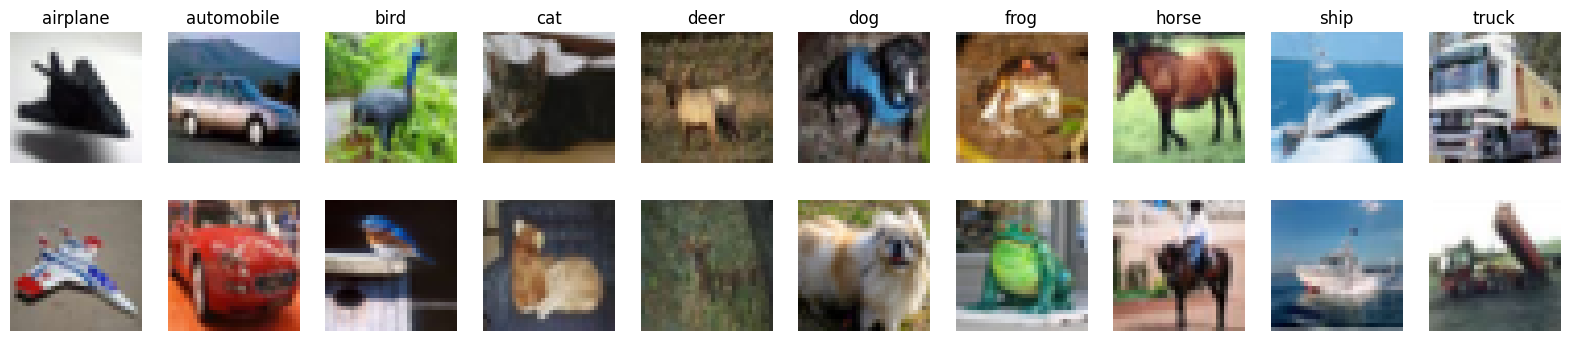

In [ ]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

### 1.4: Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load weights
model = create_model()
model.load_state_dict(torch.load('checkpoint/model_weights.pth'))
model.to(device);

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20


<ipython-input-12-437e1a9a2415>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/model_weights.pth'))
/usr/local/lib/python3.10/

In [ ]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    #scheduler
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")



Epoch [1/20]: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s, loss=1.6]


Epoch [1/20], Average Loss: 1.8927
Validation Loss: 1.5748


Epoch [2/20]: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s, loss=1.36]


Epoch [2/20], Average Loss: 1.4614
Validation Loss: 1.3641


Epoch [3/20]: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s, loss=1.29]


Epoch [3/20], Average Loss: 1.3183
Validation Loss: 1.2013


Epoch [4/20]: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s, loss=1.12]


Epoch [4/20], Average Loss: 1.2415
Validation Loss: 1.1158


Epoch [5/20]: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s, loss=1.16]


Epoch [5/20], Average Loss: 1.1955
Validation Loss: 1.1421


Epoch [6/20]: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s, loss=1.17]


Epoch [6/20], Average Loss: 1.1558
Validation Loss: 1.0248


Epoch [7/20]: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s, loss=1.2]


Epoch [7/20], Average Loss: 1.1242
Validation Loss: 1.0691


Epoch [8/20]: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s, loss=1.05]


Epoch [8/20], Average Loss: 1.0873
Validation Loss: 1.0924


Epoch [9/20]: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s, loss=1.17]


Epoch [9/20], Average Loss: 1.0742
Validation Loss: 1.0765


Epoch [10/20]: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s, loss=1.11]


Epoch [10/20], Average Loss: 1.0549
Validation Loss: 1.1034


Epoch [11/20]: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s, loss=0.975]


Epoch [11/20], Average Loss: 1.0334
Validation Loss: 0.9793


Epoch [12/20]: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s, loss=0.892]


Epoch [12/20], Average Loss: 1.0200
Validation Loss: 0.9834


Epoch [13/20]: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s, loss=1.05]


Epoch [13/20], Average Loss: 1.0076
Validation Loss: 0.9967


Epoch [14/20]: 100%|██████████| 98/98 [00:17<00:00,  5.57it/s, loss=1.01]


Epoch [14/20], Average Loss: 0.9907
Validation Loss: 1.0816


Epoch [15/20]: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s, loss=1.03]


Epoch [15/20], Average Loss: 0.9824
Validation Loss: 0.9701


Epoch [16/20]: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s, loss=0.916]


Epoch [16/20], Average Loss: 0.9640
Validation Loss: 0.9109


Epoch [17/20]: 100%|██████████| 98/98 [00:17<00:00,  5.72it/s, loss=1.01]


Epoch [17/20], Average Loss: 0.9515
Validation Loss: 1.0623


Epoch [18/20]: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s, loss=0.893]


Epoch [18/20], Average Loss: 0.9411
Validation Loss: 0.8996


Epoch [19/20]: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s, loss=0.918]


Epoch [19/20], Average Loss: 0.9281
Validation Loss: 0.8274


Epoch [20/20]: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s, loss=0.948]


Epoch [20/20], Average Loss: 0.9218
Validation Loss: 0.8889


Best validation loss: 0.8274


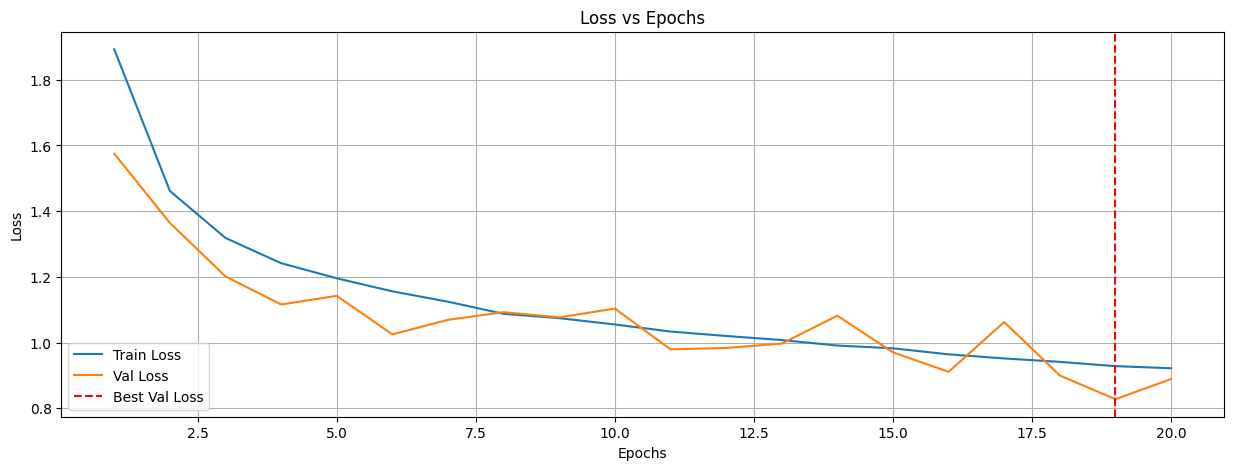

In [ ]:
# Plot the losses after training
# epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

####  **Problems**

- **Validation Loss Fluctuations:**
The validation loss fluctuates more compared to the smooth decrease in training loss, indicating that the model may be struggling to generalize consistently and could be showing signs of overfitting. These fluctuations suggest that the model might be memorizing the training data rather than generalizing well to unseen data.

- **Validation Loss Increases After Best Epoch:**
After reaching the best validation loss, further improvements stop, and the validation loss begins to fluctuate again. This indicates that the model has already reached its optimal performance, and additional training does not improve validation accuracy, potentially leading to overfitting.

####  **Solutions**

- **Early Stopping:**

 Training should have been stopped at the point where the validation loss reached its lowest value (around epoch 18).

- **Stronger Regularization:**

 Increasing dropout or adding more data augmentation techniques can help prevent overfitting.

- **Learning Rate Scheduler:**

 The learning rate scheduler should step in earlier to reduce the learning rate, which can help smooth out the fluctuations in validation loss.



### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [ ]:
# accuracy
def accuracy (model, loader):
    '''
    Function to calculate the accuracy of the model on the test set
    '''
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [ ]:
# your model
model = create_model()
model.load_state_dict(torch.load('checkpoint/trained_model.pth'))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

<ipython-input-16-70bde19f0176>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/trained_model.pth'))


Your Model Train Accuracy : 71.9300
Your Model Test Accuracy : 70.1875


To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [ ]:
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"))
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

<ipython-input-17-0de5eb642db4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/best_model.pth"))


Train accuracy: 86.3800
Test Accuracy: 80.9000


# Section 2: Unlearning

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario,
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned.

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data.
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [ ]:
# #train
retain_indices_Train, forget_indices_Train = [], []

for i, (_, label) in enumerate(train_dataset):
    if label == 0:
        forget_indices_Train.append(i)
    else:
        retain_indices_Train.append(i)

retain_dataset = torch.utils.data.Subset(train_dataset, retain_indices_Train)
forget_dataset = torch.utils.data.Subset(train_dataset, forget_indices_Train)

retain_loader =DataLoader(retain_dataset, batch_size=32, shuffle=True)
forget_loader = DataLoader(forget_dataset, batch_size=32, shuffle=True)

In [ ]:
#validation
retain_indices_Val, forget_indices_Val = [], []

for i, (_, label) in enumerate(val_dataset):
    if label == 0:
        forget_indices_Val.append(i)
    else:
        retain_indices_Val.append(i)
retain_dataset_val = torch.utils.data.Subset(val_dataset, retain_indices_Val)
forget_dataset_val = torch.utils.data.Subset(val_dataset, forget_indices_Val)

retain_loader_val =  DataLoader(retain_dataset_val, batch_size=32, shuffle=True)
forget_loader_val = DataLoader(forget_dataset_val, batch_size=32, shuffle=True)


In [ ]:
# #test

retain_indices_Test, forget_indices_Test = [], []

for i, (_, label) in enumerate(test_dataset):
    if label == 0:
        forget_indices_Test.append(i)
    else:
        retain_indices_Test.append(i)
retain_dataset_test = torch.utils.data.Subset(test_dataset, retain_indices_Test)
forget_dataset_test = torch.utils.data.Subset(test_dataset, forget_indices_Test)

retain_loader_test = DataLoader(retain_dataset_test, batch_size=32, shuffle=True)
forget_loader_test =  DataLoader(forget_dataset_test, batch_size=32, shuffle=True)

### 2.2: Training Loop

In [ ]:
def unlearning( model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch/len(retain_loader)
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")


    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [ ]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, retain_loader_val, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

<ipython-input-22-98f15de35c78>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))
Epoch [1/10]: 100%|███

Epoch [1/10], Average Loss: 0.5782
Validation Loss: 0.5427


Epoch [2/10]: 100%|██████████| 1407/1407 [00:28<00:00, 49.14it/s, loss=1.22]


Epoch [2/10], Average Loss: 0.5636
Validation Loss: 0.5301


Epoch [3/10]: 100%|██████████| 1407/1407 [00:28<00:00, 49.19it/s, loss=0.983]


Epoch [3/10], Average Loss: 0.5518
Validation Loss: 0.5322


Epoch [4/10]: 100%|██████████| 1407/1407 [00:28<00:00, 48.56it/s, loss=0.707]


Epoch [4/10], Average Loss: 0.5524
Validation Loss: 0.5108


Epoch [5/10]: 100%|██████████| 1407/1407 [00:28<00:00, 48.87it/s, loss=0.826]


Epoch [5/10], Average Loss: 0.5451
Validation Loss: 0.5405


Epoch [6/10]: 100%|██████████| 1407/1407 [00:30<00:00, 46.66it/s, loss=0.53]


Epoch [6/10], Average Loss: 0.5464
Validation Loss: 0.5286


Epoch [7/10]: 100%|██████████| 1407/1407 [00:28<00:00, 48.75it/s, loss=0.73]


Epoch [7/10], Average Loss: 0.5435
Validation Loss: 0.5232


Epoch [8/10]: 100%|██████████| 1407/1407 [00:28<00:00, 49.07it/s, loss=0.6]


Epoch [8/10], Average Loss: 0.5446
Validation Loss: 0.5164


Epoch [9/10]: 100%|██████████| 1407/1407 [00:28<00:00, 48.75it/s, loss=0.431]


Epoch [9/10], Average Loss: 0.5407
Validation Loss: 0.5204


Epoch [10/10]: 100%|██████████| 1407/1407 [00:28<00:00, 48.52it/s, loss=1.53]


Epoch [10/10], Average Loss: 0.5314
Validation Loss: 0.5247


<ipython-input-21-b6be18bb05b6>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/forget_model.pth"))


**Below there is the evaluation of your unlearned by fine-tuning model**

In [ ]:
# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}") # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

<ipython-input-23-ef6d8225271a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));


Retain set Accuracy: 88.2956
Forget set Accuracy: 9.3600
Test set Accuracy: 75.5125
Test set Retain Accuracy: 82.9445
Test set Forget Accuracy: 8.6250


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A:
 The values observed during training and testing provide significant insights into the model's performance, particularly regarding its ability to retain or forget information.

Training Accuracy
1. Retain Set Accuracy: This relatively high accuracy indicates that the model performs well on the "Retain" examples, successfully learning and generalizing the relevant features from this subset of data. The model is effectively trained on the subset of data which was supposed to be retained.
2. Forget Set Accuracy: In contrast, the low accuracy on the "Forget" examples suggests that the model is not performing well on this subset of data. This implies that the model has effectively "forgotten" the information it was instructed to disregard, resulting in poor performance.

Testing Accuracy:
3. Overall Test Set Accuracy: This value reflects the model's general performance across all test data. While the accuracy is decent, it is influenced by the performance on both "Retain" and "Forget" subsets.
4. Test Set Retain Accuracy: This accuracy shows that the model still performs reasonably well on the "Retain" examples during testing, which aligns with the training results and indicates that the model has successfully retained the necessary information.
5. Test Set Forget Accuracy: The low accuracy for the "Forget" examples at test time reinforces the idea that the model has effectively forgotten the data it was supposed to disregard. This is consistent with the training accuracy for the "Forget" set, indicating that the forgetting process has been successful.

# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [ ]:
# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
gold_model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

<ipython-input-24-5fd5eaff0a96>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))


#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [ ]:
# **IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

losses = []
losses_val = []
best_loss = float('inf')

for epoch in range(num_epochs):

    gold_model.train()
    running_loss = 0

    loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)

    for batch_idx, (data, targets) in loop:

        data, targets = data.to(device), targets.to(device)

        # Forward pass
        scores = gold_model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Average loss for this epoch
    avg_loss = running_loss / len(retain_loader)
    losses.append(avg_loss)

    # Scheduler step
    scheduler.step(avg_loss)

    ######### VALIDATION ##########
    gold_model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in retain_loader_val:
            data, targets = data.to(device), targets.to(device)

            scores = gold_model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

    # Average validation loss
    avg_val_loss = val_loss / len(retain_loader_val)
    losses_val.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")
        print(f"Model saved at epoch {epoch+1} with validation loss: {best_loss:.4f}")


Epoch [1/20]: 100%|██████████| 1407/1407 [00:28<00:00, 48.77it/s, loss=1.45]


Epoch [1/20], Train Loss: 1.8637, Val Loss: 1.5141
Model saved at epoch 1 with validation loss: 1.5141


Epoch [2/20]: 100%|██████████| 1407/1407 [00:28<00:00, 48.77it/s, loss=1.41]


Epoch [2/20], Train Loss: 1.4955, Val Loss: 1.3141
Model saved at epoch 2 with validation loss: 1.3141


Epoch [3/20]: 100%|██████████| 1407/1407 [00:28<00:00, 48.70it/s, loss=1.97]


Epoch [3/20], Train Loss: 1.3612, Val Loss: 1.2090
Model saved at epoch 3 with validation loss: 1.2090


Epoch [4/20]: 100%|██████████| 1407/1407 [00:28<00:00, 48.97it/s, loss=1.37]


Epoch [4/20], Train Loss: 1.2934, Val Loss: 1.1677
Model saved at epoch 4 with validation loss: 1.1677


Epoch [5/20]: 100%|██████████| 1407/1407 [00:29<00:00, 47.22it/s, loss=1.17]


Epoch [5/20], Train Loss: 1.2354, Val Loss: 1.1640
Model saved at epoch 5 with validation loss: 1.1640


Epoch [6/20]: 100%|██████████| 1407/1407 [00:28<00:00, 48.72it/s, loss=1.14]


Epoch [6/20], Train Loss: 1.2064, Val Loss: 1.0760
Model saved at epoch 6 with validation loss: 1.0760


Epoch [7/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.26it/s, loss=1.49]


Epoch [7/20], Train Loss: 1.1769, Val Loss: 1.0289
Model saved at epoch 7 with validation loss: 1.0289


Epoch [8/20]: 100%|██████████| 1407/1407 [00:28<00:00, 49.02it/s, loss=1.65]


Epoch [8/20], Train Loss: 1.1516, Val Loss: 1.0361


Epoch [9/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.16it/s, loss=1.25]


Epoch [9/20], Train Loss: 1.1314, Val Loss: 0.9896
Model saved at epoch 9 with validation loss: 0.9896


Epoch [10/20]: 100%|██████████| 1407/1407 [00:29<00:00, 47.87it/s, loss=1.58]


Epoch [10/20], Train Loss: 1.1134, Val Loss: 0.9894
Model saved at epoch 10 with validation loss: 0.9894


Epoch [11/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.17it/s, loss=0.901]


Epoch [11/20], Train Loss: 1.0924, Val Loss: 1.0351


Epoch [12/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.41it/s, loss=1.64]


Epoch [12/20], Train Loss: 1.0780, Val Loss: 1.0224


Epoch [13/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.03it/s, loss=0.974]


Epoch [13/20], Train Loss: 1.0658, Val Loss: 1.0297


Epoch [14/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.23it/s, loss=1]


Epoch [14/20], Train Loss: 1.0565, Val Loss: 0.9509
Model saved at epoch 14 with validation loss: 0.9509


Epoch [15/20]: 100%|██████████| 1407/1407 [00:30<00:00, 46.44it/s, loss=1.14]


Epoch [15/20], Train Loss: 1.0435, Val Loss: 1.0051


Epoch [16/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.12it/s, loss=1.13]


Epoch [16/20], Train Loss: 1.0290, Val Loss: 0.9641


Epoch [17/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.46it/s, loss=1.26]


Epoch [17/20], Train Loss: 1.0238, Val Loss: 0.8975
Model saved at epoch 17 with validation loss: 0.8975


Epoch [18/20]: 100%|██████████| 1407/1407 [00:29<00:00, 47.28it/s, loss=0.953]


Epoch [18/20], Train Loss: 1.0151, Val Loss: 0.8828
Model saved at epoch 18 with validation loss: 0.8828


Epoch [19/20]: 100%|██████████| 1407/1407 [00:29<00:00, 48.45it/s, loss=1.11]


Epoch [19/20], Train Loss: 1.0054, Val Loss: 0.9215


Epoch [20/20]: 100%|██████████| 1407/1407 [00:28<00:00, 48.86it/s, loss=0.987]


Epoch [20/20], Train Loss: 0.9950, Val Loss: 0.9070


Best validation loss: 0.8828


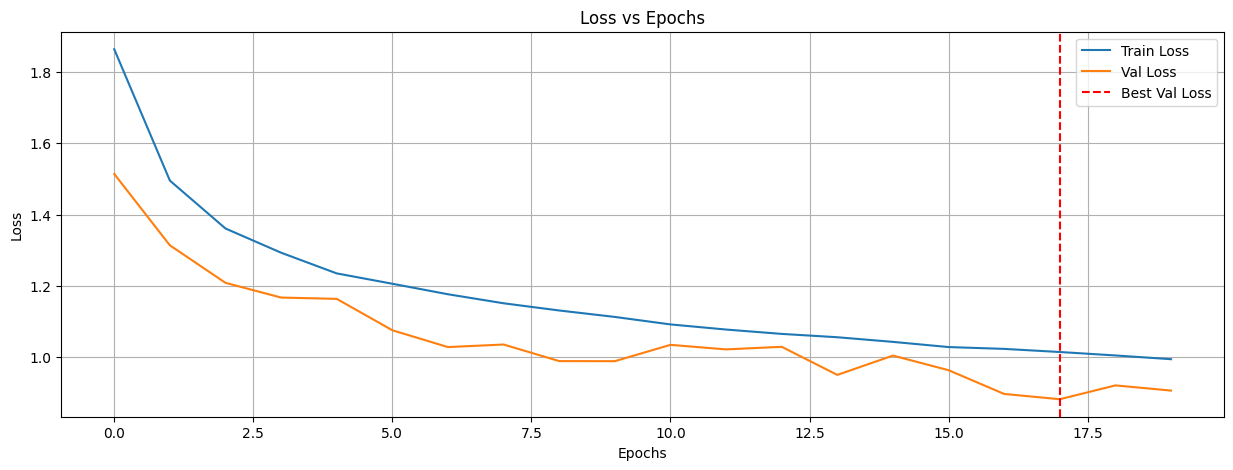

In [ ]:

#epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [ ]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

<ipython-input-27-6b6d4f58631d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))


Retain set Accuracy: 69.4489
Forget set Accuracy: 0.0000
Test set Accuracy: 61.6375
Test set Retain Accuracy: 68.4861
Test set Forget Accuracy: 0.0000


#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A:

### Train and Validation Loss:

The graph shows that both the training (train) loss and validation loss decrease over time. While the train loss gradually decreases, the validation loss follows a similar downward trend. This indicates that the model is successfully learning from the retain set. However, there are minor fluctuations in validation loss, suggesting a slight risk of overfitting to the retain set data.

### Accuracy Results:

- **Retain Set Accuracy**: The retain set accuracy is at a high level, indicating that the model has adapted well to the retain set data and performs strongly on this set.

- **Forget Set Accuracy**: The model achieves 0% accuracy on the forget set, which shows that the unlearning process was successful, as the model was expected to "forget" this set. This confirms that the model has effectively unlearned the classes in the forget set and focused on the retain set.

- **Test Set Accuracy**: The overall accuracy on the test set is lower than on the retain set, due to the presence of forget classes in the test set.

- **Test Set Retain Accuracy**: The accuracy for retain classes within the test set is close to the retain set accuracy, indicating that the model performs consistently well on retain classes.

- **Test Set Forget Accuracy**: The accuracy on the forget classes in the test set is also , confirming that the model has completely unlearned these classes.

### Conclusion:
The model has completely unlearned the forget set, achieving 0% accuracy on these classes. This outcome confirms that the unlearning process worked as intended.


# Section 5: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [ ]:
def compute_losses(model, loader, criterion = "CrossEntropy"):

    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = nn.CrossEntropyLoss(reduction = "none")(logits, targets).detach().cpu().numpy()

        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


In [ ]:
#model
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"));
model.eval()
model.to(device);

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)


<ipython-input-29-f9c6c668a82f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/best_model.pth"));


In [ ]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)


<ipython-input-30-5d11afc7d1f9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));


In [ ]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"));
gold_model.eval()
gold_model.to(device);

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

<ipython-input-31-b71f6c8518b8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"));


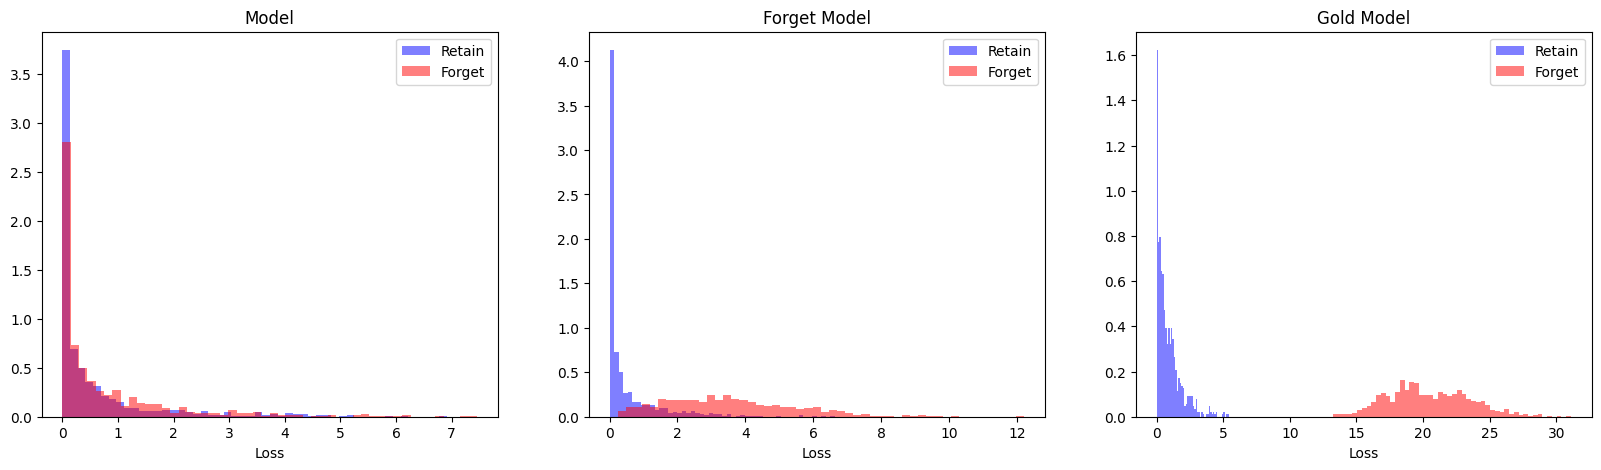

In [ ]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(len(retain_losses)), len(forget_losses), replace=False)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(retain_losses, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].hist(retain_losses_forget, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_forget, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Forget Model')
axs[1].set_xlabel('Loss')
axs[1].legend()

axs[2].hist(retain_losses_gold, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_gold, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Gold Model')
axs[2].set_xlabel('Loss')
axs[2].legend()

plt.show()

In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    torch.manual_seed(torch.initial_seed())

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )

    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy",
    )

In [ ]:
# mia on model
retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
#balance the number of samples
members_mia = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

Model MIA score: 0.5431


In [ ]:
#mia on forget model
retain_losses_forget_subsample = np.random.choice(retain_losses_forget, len(forget_losses_forget), replace=False)
samples_mia = np.concatenate([retain_losses_forget_subsample, forget_losses_forget]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))])

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

Forget Model MIA score: 0.8863


In [ ]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(retain_losses_gold, len(forget_losses_gold), replace=False)
samples_mia = np.concatenate([retain_losses_gold_subsample, forget_losses_gold]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))])

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

Gold Model MIA score: 1.0000


#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A:

# Evaluation of Histograms:

**Model (First chart):**

In the first chart, the loss distributions for "Retain" (blue) and "Forget" (red) examples are shown together, as the model was trained on all data without selective forgetting. This suggests that the model has learned general patterns across the entire dataset rather than isolating specific features for "Retain" or "Forget" examples. Consequently, both types of data exhibit similar low loss values, indicating that the model is not distinguishing between them. This likely occurs because the model has focused on features common to both types, resulting in comparable performance across "Retain" and "Forget" examples.

**Second chart:**

In the second chart, the model has undergone a forgetting process. The "Forget" examples exhibit a broader distribution with higher loss values than the "Retain" examples, indicating that the model now performs worse on the forgotten data. This suggests that the forgetting process successfully removed certain information from the model, leading to reduced performance on the "Forget" examples. Meanwhile, the model maintains lower loss values for the "Retain" examples, showing that it has selectively preserved performance on the data it was meant to remember.

**Third Chart:**

In the third chart, the "Gold Model" illustrates an ideal outcome of the forgetting process, with a clear distinction in loss values between "Retain" (blue) and "Forget" (red) data. The losses for "Forget" examples are spread across a higher range, indicating that this data was not included in the Gold Model's training. Since the Gold Model has never been exposed to "Forget" data, it produces significantly high losses for these examples, demonstrating that the intended data has been successfully removed from the model's memory. Conversely, the model shows low loss values for "Retain" examples, reflecting strong performance and confirming that it has effectively preserved information on the data it was meant to remember. This outcome meets the objective of selective forgetting.


# Evaluation of MIA Attack Results:

MIA  scores provide a more quantitative assessment of the model’s success in remembering or forgetting training data.

**Model (First Model, MIA Score: 0.5431):**  

This low MIA score indicates that the model is not very successful at remembering training data. In other words, an attacker would find it difficult to determine whether a specific data point was included in the training set by using this model. This offers a more privacy-secure structure.

**Forget Model (Forget Model, MIA Score: 0.8863):**  

Forget Model has a fairly high MIA score, indicating that, despite the forgetting process, the model can still distinguish forgotten data. This high score signals a privacy risk, as the model recognizes forgotten data, making it more likely that an attacker could identify training data.

**Gold Model (Gold Model, MIA Score: 1.000):**  

Gold Model has an almost perfect MIA score (1.000). This score shows that the model can distinguish data not included in training with very high accuracy. Therefore, an attacker can easily identify training data with this model, making it the highest-risk model in terms of privacy.




# 6. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point)

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A:

**Objective of Unlearning:**

KL divergence is a metric that measures how "distant" one distribution is from another. In this context, our goal is for the model to perform the unlearning process by "forgetting" the specific information related to certain classes, essentially making it view those classes as a uniform distribution. For the forgotten class, we want the model's predictions to resemble a uniform distribution, like $[0.25,0.25,0.25,0.25]$. KL divergence measures the difference between two distributions, allowing us to evaluate how close the predictions are to the uniform distribution.

**Limitations of Cross-Entropy:**

 Cross-Entropy is typically used to measure how close the model's prediction is to a specific "correct" class and is more effective in cases where there is a single correct class. However, here we want to maintain equal weight for all classes, meaning we are not labeling any specific class as "correct." In this case, Cross-Entropy cannot adequately capture these differences and is ineffective in measuring how close the predictions are to the uniform distribution.

In [ ]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

'''
Add your code below
'''


cross_entropy = F.nll_loss(y_pred.log().unsqueeze(0), y_gt.unsqueeze(0).argmax().unsqueeze(0))
kl_div = F.kl_div(y_pred.log(), y_gt, reduction="batchmean")

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

Cross Entropy: 1.3863
KL Divergence: 0.0000


**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

A:

### Relationship Between Cross-Entropy and Kullback-Leibler (KL) Divergence

Cross-Entropy and KL Divergence are closely related metrics, both of which measure the difference between two probability distributions. To understand their relationship, let's break down each concept and derive the connection between them.

#### Definitions

1. **Cross-Entropy**: Cross-Entropy between a true distribution $p$ and a predicted distribution $q$ is defined as:

   $$
   H(p, q) = -\sum_{i} p(i) \log q(i)
   $$

   This measures the "cost" of predicting $q$ when the true distribution is $p$.

2. **Kullback-Leibler (KL) Divergence**: KL Divergence measures the difference between the two distributions $p$ and $q$, and it is given by:

   $$
   D_{KL}(p \| q) = \sum_{i} p(i) \log \frac{p(i)}{q(i)}
   $$

   KL Divergence tells us how much extra "information" would be required to describe $p$ if we use $q$ instead of $p$.

#### Derivation of the Relationship

To derive the relationship between Cross-Entropy and KL Divergence, we start by noting that **the Cross-Entropy $H(p, q)$ can be decomposed into the sum of the Entropy of $p$ and the KL Divergence between $p$ and $q$**.

1. **Entropy of $p$**: The entropy of the true distribution $p$ is:

   $$
   H(p) = -\sum_{i} p(i) \log p(i)
   $$

   This represents the average amount of "uncertainty" or "information" in the distribution $p$.

2. **Decomposing Cross-Entropy**:
   $$
   H(p, q) = -\sum_{i} p(i) \log q(i)
   $$
   We can rewrite this by adding and subtracting $p(i) \log p(i)$ inside the summation:
   $$
   H(p, q) = -\sum_{i} p(i) \log p(i) + \sum_{i} p(i) \log \frac{p(i)}{q(i)}
   $$
   This simplifies to:
   $$
   H(p, q) = H(p) + D_{KL}(p \| q)
   $$

### Interpretation of the Relationship

This shows that **Cross-Entropy $H(p, q)$ is equal to the Entropy of the true distribution $p$ plus the KL Divergence between $p$ and $q$**. In other words:

$$
H(p, q) = H(p) + D_{KL}(p \| q)
$$

This means:
- **If $p$ and $q$ are identical**, then $D_{KL}(p \| q) = 0$, and Cross-Entropy is simply the entropy of $p$.
- **If $p$ and $q$ differ**, then $D_{KL}(p \| q) > 0$, meaning Cross-Entropy will be larger than the entropy of $p$, with the difference representing the "extra cost" of using $q$ to approximate $p$.

### Application in Unlearning

In the unlearning context, we want the predicted distribution $q$ to resemble a uniform distribution when $p$ is also uniform (e.g., $[0.25, 0.25, 0.25, 0.25]$). Using **KL Divergence** allows us to measure how close $q$ is to this uniform target distribution. Since both $p$ and $q$ are uniform in this scenario, KL Divergence becomes zero, confirming that the model has "forgotten" specific information about the classes.



In [ ]:
#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def make_target (target, number_of_classes = 10):
    '''
    Function to modify the target class
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.nn.functional.one_hot(target, num_classes= number_of_classes ).float().to(device)
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0

    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full((n,), 1.0 / n, device = device)  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [ ]:
def unlearning_2 (model, forget_loader, validation, epochs, optimizer, scheduler):
    '''
    Function to unlearn the forget set
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)

            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction='batchmean')
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(forget_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction='batchmean')
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [ ]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"));
another_forget_model.to(device);

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(another_forget_model, forget_loader, val_loader, num_epochs, optimizer, scheduler)

<ipython-input-41-24feaf927bd5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"));
/usr/local/li

Epoch [1/10], Average Loss: 0.8670
Validation Loss: 0.4038


Epoch [2/10]: 100%|██████████| 157/157 [00:03<00:00, 43.60it/s, loss=0.25]


Epoch [2/10], Average Loss: 0.3141
Validation Loss: 0.1775


Epoch [3/10]: 100%|██████████| 157/157 [00:03<00:00, 46.82it/s, loss=0.221]


Epoch [3/10], Average Loss: 0.1699
Validation Loss: 0.1011


Epoch [4/10]: 100%|██████████| 157/157 [00:02<00:00, 53.42it/s, loss=0.273]


Epoch [4/10], Average Loss: 0.1158
Validation Loss: 0.0641


Epoch [5/10]: 100%|██████████| 157/157 [00:03<00:00, 51.56it/s, loss=0.086]


Epoch [5/10], Average Loss: 0.0818
Validation Loss: 0.0407


Epoch [6/10]: 100%|██████████| 157/157 [00:03<00:00, 45.86it/s, loss=0.0514]


Epoch [6/10], Average Loss: 0.0618
Validation Loss: 0.0292


Epoch [7/10]: 100%|██████████| 157/157 [00:03<00:00, 41.89it/s, loss=0.063]


Epoch [7/10], Average Loss: 0.0496
Validation Loss: 0.0200


Epoch [8/10]: 100%|██████████| 157/157 [00:03<00:00, 51.81it/s, loss=0.0542]


Epoch [8/10], Average Loss: 0.0399
Validation Loss: 0.0167


Epoch [9/10]: 100%|██████████| 157/157 [00:03<00:00, 49.73it/s, loss=0.036]


Epoch [9/10], Average Loss: 0.0338
Validation Loss: 0.0146


Epoch [10/10]: 100%|██████████| 157/157 [00:03<00:00, 51.39it/s, loss=0.0408]


Epoch [10/10], Average Loss: 0.0279
Validation Loss: 0.0093


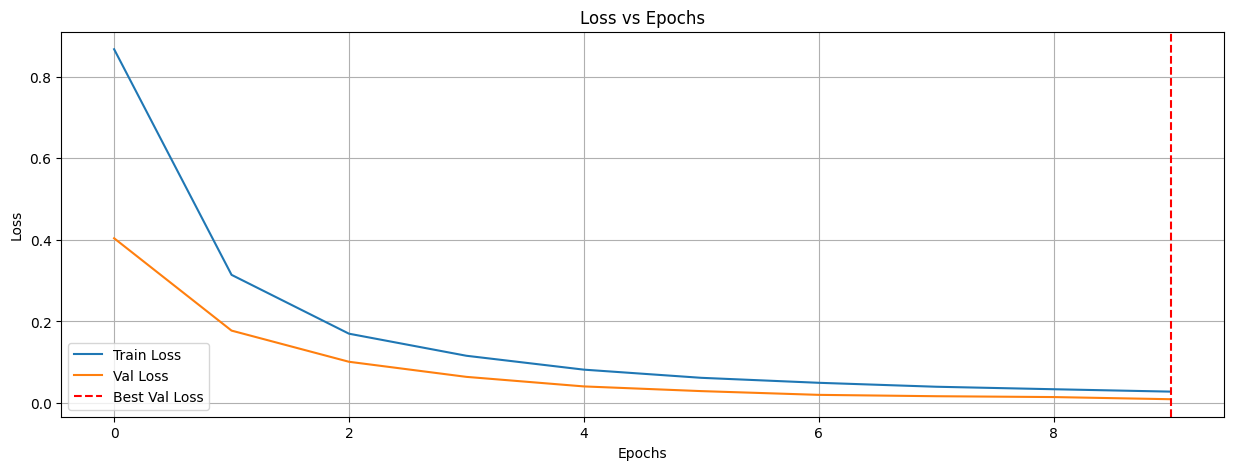

In [ ]:
#plot losses
#epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [ ]:
# calculate accuracy
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

<ipython-input-43-c1f19255cae9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))


In [ ]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

Retain Accuracy: 26.9978
Forget Accuracy: 16.1800
Test Accuracy: 24.9875
Test Retain Accuracy: 25.8889
Test Forget Accuracy: 16.8750


In [ ]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

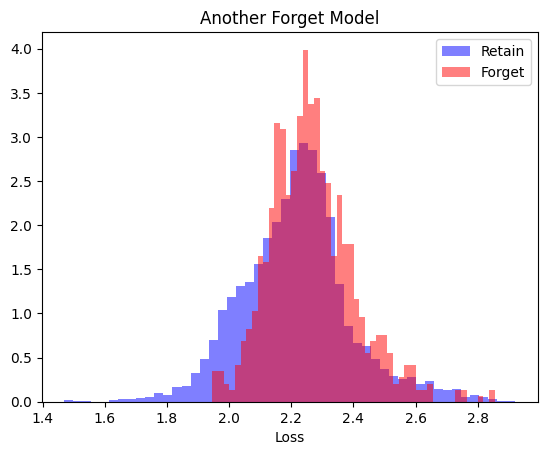

In [ ]:
plt.hist(retain_losses_CE, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses_CE, density = True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Another Forget Model')
plt.xlabel('Loss')
plt.legend()
plt.show()

Note: retain loss should be more low

In [ ]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(retain_losses_CE, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))])

scores_another_forget = simple_mia(samples_mia, members_mia)
print(f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}")

Another Forget Model MIA score with Cross Entropy losses: 0.5600


This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.0%2Bcu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0%2Bcu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 101.4 MB/s eta 0:00:00


In [ ]:
from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN

torch.manual_seed(0)

weights = torch.load("checkpoint/best_model.pth")
model = create_model()
model.load_state_dict(weights)
arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
x = x.float()
edge_attr = edge_attr.float()

# currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))

graph_batch = Batch.from_data_list([g_cnn])
print(graph_batch)

DataBatch(x=[216, 3], edge_index=[2, 59050], edge_attr=[59050, 6], u=[1, 8], batch=[216], ptr=[2])


<ipython-input-49-20181f531080>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/best_model.pth")


In [ ]:
class GraphMetaNetwork(nn.Module):
    '''
    Wrapper class for the graph metanetwork
    '''
    def __init__(self, encoder, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return edge_attr

# Define the encoder and MPNN
pre_embedding_dim = 64
global_in_dim = 8
hidden_dim = 32
node_out_dim = 3
edge_out_dim = 1
global_out_dim = 8
num_gnn_layers = 4
encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
mpnn = MPNN(node_in_dim=pre_embedding_dim,
            edge_in_dim=pre_embedding_dim,
            global_in_dim = global_in_dim,
            hidden_dim=hidden_dim,
            node_out_dim= node_out_dim,
            edge_out_dim = edge_out_dim,
            global_out_dim= global_out_dim,
            num_layers=num_gnn_layers,
            reduce='mean')

# Create the metanetwork
gmn = GraphMetaNetwork(encoder, mpnn)
gmn.to(device)

GraphMetaNetwork(
  (encoder): NodeEdgeFeatEncoder(
    (node_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (neuron_num_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (node_type_encoder): Embedding(17, 64)
    (x_proj): Linear(in_features=192, out_features=64, bias=True)
    (weight_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (conv_pos_encoder): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_type_encoder): Embedding(14, 64)
    (edge_attr_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (mpnn): MPNN(
    (convs): ModuleList(
      (0): MetaLayer(
        edge_model=EdgeModel(
        (edge_mlp): S

If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

In [ ]:
from torch_geometric.data import Data, DataLoader, Batch
import torch
import torch.nn as nn
from torch.utils.data import Subset

def create_graph_dataset(model, dataset, retain_label=1, forget_label=0):
    graph_data = []
    for inputs, label in dataset:
        if label not in {retain_label, forget_label}:
            continue
        arch = sequential_to_arch(model)
        x, edge_index, edge_attr = arch_to_graph(arch)
        x, edge_attr = x.float(), edge_attr.float()
        graph_data.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr,  u=torch.zeros(1, 8)))
    return graph_data


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def trainingGMNunlearning(gmn, retain_loader, criterion, optimizer, epochs=5):
    # gmn = gmn.to(device)

    gmn.train()
    for epoch in range(epochs):
        total_loss = 0

        for data in retain_loader:  # data is already a Data object, not a list
            data = data.to(device)  # Ensure data is on the correct device
            optimizer.zero_grad()  # reset gradients for the optimizer
            edge_attr = gmn(data)  # forward pass to predict edge attributes
            loss = criterion(edge_attr, data.edge_attr)  # compute the loss between predictions and true edge attributes
            loss.backward(retain_graph=True)  # backpropagate the loss to compute gradients
            optimizer.step()  # update the model parameters by the optimizer
            total_loss += loss.item()  # add loss

        # Print average loss for the epoch.
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(retain_loader):.4f}")


In [ ]:
# Ensure everything is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def UnlearnEvaluateUsingMIA(model, retain_loader, forget_loader, validation_loader):
    # Convert sequential model to a graph representation
    arch = sequential_to_arch(model)
    x, edge_index, edge_attr = arch_to_graph(arch)
    x, edge_attr = x.float(), edge_attr.float()  # Ensure float type for compatibility.

    # Graph representation
    g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    g_cnn.u = torch.zeros(1, 8).to(device)  # Move 'u' tensor to the correct device

    # Move graph data to the same device
    graph_batch = Batch.from_data_list([g_cnn]).to(device)



    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Training process
    trainingGMNunlearning(model, retain_loader, criterion, optimizer)

    # Updating the model with the trained GMN
    gmn.eval()  # Set GMN to evaluation mode
    updated_edge_attr = gmn(graph_batch)  # Predict updated edge attributes
    # Convert architecture to a sequential model
    updated_arch = graph_to_arch(arch, updated_edge_attr)
    updated_model = arch_to_sequential(updated_arch, model)

    # Evaluate the updated model on retain, forget, and validation datasets
    updated_model.eval()  # Set to evaluation mode
    retain_accuracy = accuracy(updated_model, retain_loader)
    forget_accuracy = accuracy(updated_model, forget_loader)
    validation_accuracy = accuracy(updated_model, validation_loader)

    print(f"Retain Accuracy after Unlearning: {retain_accuracy:.4f}")
    print(f"Forget Accuracy after Unlearning: {forget_accuracy:.4f}")
    print(f"Validation Accuracy after Unlearning: {validation_accuracy:.4f}")

    # Membership Inference Attack (MIA) to assess privacy leakage.
    retain_losses = compute_losses(updated_model, retain_loader)  # Losses on retained data
    forget_losses = compute_losses(updated_model, forget_loader)  # Losses on forgotten data
    mia_score = simple_mia(retain_losses, forget_losses)  # Get MIA score from losses

    print(f"MIA Score after Unlearning: {mia_score:.4f}")

    return updated_model


In [ ]:
# model = create_model()
# model.load_state_dict(torch.load("checkpoint/best_model.pth"))
# model.eval()
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Dropout(p=0.1, inplace=False)
  (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): AdaptiveAvgPool2d(output_size=(1, 1))
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=64, out_features=32, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.1, inplace=False)
  (19): Linear(in_features=32, out_features=10,

In [ ]:
from torch_geometric.data import DataLoader  # This is the correct DataLoader for graphs
#subset was created for faster training time
# Parameters
retain_label = 1
forget_label = 0
subset_size = 2
batch_size = 16

# Create a subset of the training dataset
if isinstance(train_dataset, list):
    # training dataset is a list object
    filtered_samples = [
        sample for sample in train_dataset if sample[1] in {retain_label, forget_label}
    ]
    # samples with the target labels (retain or forget)
    subset = filtered_samples[:subset_size]
else:
    # training dataset is a PyTorch Dataset object
    subset_indices = [
        i for i, sample in enumerate(train_dataset) if sample[1] in {retain_label, forget_label}
    ]
    # indices of samples with the target labels
    subset_indices = subset_indices[:subset_size]
    subset = Subset(train_dataset, subset_indices)

# Graph datasets for retain, forget, validation
retain_graphs = create_graph_dataset(model, subset, retain_label=retain_label, forget_label=forget_label)  # dataset for retain
forget_graphs = create_graph_dataset(model, subset, retain_label=forget_label, forget_label=retain_label)  # dataset for forget
val_graphs = create_graph_dataset(model, val_dataset, retain_label=retain_label, forget_label=forget_label)  # dataset for validation

# DataLoaders for batching the graph datasets using the correct DataLoader
retain_loader = DataLoader(retain_graphs, batch_size=batch_size, shuffle=True)  # DataLoader for retain
unlearn_loader = DataLoader(forget_graphs, batch_size=batch_size, shuffle=True)  # DataLoader for forget task
validation_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)  # DataLoader for validation

# Now, call your function to unlearn and evaluate
updated_model = UnlearnEvaluateUsingMIA(model, retain_loader, unlearn_loader, validation_loader)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


TypeError: conv2d() received an invalid combination of arguments - got (DataBatch, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!DataBatch!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!DataBatch!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


## Report

Unlearning in machine learning allows a model to selectively forget certain learned data while retaining important information. In a GMN, unlearning impacts the model’s structure by modifying its graph representation. Specifically, it alters or removes certain edges and nodes associated with forgotten data, and updates the edge attributes to reduce the influence of unwanted information. This enables the GMN to adapt and focus on retaining the most relevant knowledge, ensuring that the model forgets targeted data while preserving its performance on the retained data.

This code shows how to convert a CNN into a graph representation for an unlearning task. Weights are loaded from the best_model.pth file. The CNN model's architecture is transformed into a sequential representation using the sequential_to_arch function, then converted into a graph structure using the arch_to_graph function. This process outputs nodes (x), edges (edge_attr), and edge connectivity indices (edge_index). These graph components are then encapsulated into a single graph (g_cnn) and batched to be processed as a collection of graphs during model training.

The trainingGMNunlearning function trains a GMN to selectively unlearn certain features while retaining others. During training, the model processes graph-structured data in mini-batches drawn from the retain_loader. Each batch is transformed into a PyTorch Geometric Batch object. The GMN predicts edge attributes for the graph, which are then compared against the ground truth using a loss function. The function tracks the total loss across all batches and reports the average loss per epoch, enabling the evaluation of model performance over time. This approach allows the GMN to modify its graph-based architecture and fine-tuning the model for selective unlearning tasks. The updated model is evaluated for accuracy across three datasets: retain, forget, and validation. Also, a MIA simulation evaluates privacy risks by calculating a score based on the model’s ability to differentiate between retained and forgotten data, quantifying the effectiveness of the unlearning process.
